In [134]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt

regr = RandomForestRegressor(max_depth=2,random_state=0)

In [135]:
import csv
import os
import numpy as np
import pandas
dir_path = os.path.dirname(os.path.realpath('feature_selection.ipynb'))
datasets_folder = dir_path +'/datasets'

filenames = []
for file in os.listdir(datasets_folder):
    filenames.append(os.fsdecode(file))
print(filenames)

['2_201_S.csv', '2_137_N.csv', '1_137_S.csv', '1_120_N.csv', '2_221_S.csv', '2_120_S.csv', '1_115_S.csv', '2_235_N.csv', '2_127_S.csv', '1_112_S.csv', '1_101_N.csv', '2_247_S.csv', '2_213_N.csv', '1_103_N.csv', '1_127_N.csv', '2_224_S.csv', '2_132_N.csv', '2_239_S.csv', '1_142_N.csv', '2_213_S.csv', '1_103_S.csv', '1_127_S.csv', '2_224_N.csv', '2_235_S.csv', '2_127_N.csv', '1_112_N.csv', '1_101_S.csv', '2_247_N.csv', '2_132_S.csv', '2_239_N.csv', '1_142_S.csv', '1_124_S.csv', '1_137_N.csv', '1_119_S.csv', '2_201_N.csv', '2_137_S.csv', '2_221_N.csv', '2_120_N.csv', '1_115_N.csv', '1_120_S.csv']


In [109]:
from sklearn.metrics import mean_squared_error

def model_fit(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    #y_pred = np.ceil(y_pred)
    mse = mean_squared_error(y_train,y_pred)
    
    #plt.plot(y_train,'ro')
    #plt.plot(y_pred,'bo')
    #plt.show()
    
    y_pred_test = model.predict(X_test)
    #y_pred_test = np.ceil(y_pred_test)
    
    return model.feature_importances_,mse,y_pred_test

# random forest

In [136]:
from sklearn.model_selection import train_test_split

def rf():
    sum_mse_train = 0
    sum_mse_test = 0
    for filename in filenames:
        filename_new = filename.replace('.csv','')
        line,stationID,stationDIR = filename_new.split('_')
        cur_dir = datasets_folder+'/'+filename
        data = pandas.read_csv(cur_dir,header=None)
        data.columns = ['month','date','hour','temp','pressure','humidity',
                       'wind_speed','wind_direction','clouds','weather_code',
                       'minute','delay']
        X = data[['hour','temp','pressure','humidity','wind_speed','clouds','weather_code','minute']]
        y = data.iloc[:,11]
        X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

        importances, mse, y_pred_test = model_fit(regr,X_train,X_test,y_train,y_test)
        sum_mse_train += mse
        sum_mse_test += mean_squared_error(y_test,y_pred_test)
        #print('new station')
        #print(importances)
    return sum_mse_train/len(filenames),sum_mse_test/len(filenames)

mse_train = 0
mse_test = 0
for i in range(10):
    train,test = rf()
    mse_train += train
    mse_test += test
print(mse_train/10)
print(mse_test/10)

3.8862287167203027
4.043676663597375


# parameter selection 

In [132]:
from sklearn.model_selection import GridSearchCV
import json

dict_para = {}
for filename in filenames:
    filename_new = filename.replace('.csv','')
    line,stationID,stationDIR = filename_new.split('_')
    cur_dir = datasets_folder+'/'+filename
    data = pandas.read_csv(cur_dir,header=None)
    data.columns = ['month','date','hour','temp','pressure','humidity',
                   'wind_speed','wind_direction','clouds','weather_code',
                   'minute','delay']
    X = data[['hour','temp','pressure','humidity','wind_speed','clouds','minute']]
    y = data.iloc[:,11]
    X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

    tuned_parameters = [{'kernel':['rbf'],
                         'gamma':[1e-3,1e-4,1e-2,0.1,1],
                         'alpha':[0.1,1,10,100,1000]}]

    clf = GridSearchCV(KernelRidge(),tuned_parameters,cv=5)
    clf.fit(X_train,y_train)
    
    dict_para[filename_new] = clf.best_params_
model_param_dir = dir_path+'/models/model_param/krr_param.json'


with open(model_param_dir, 'w') as fp:
    json.dump(dict_para, fp)

# kernel ridge regression 

In [148]:
from sklearn.kernel_ridge import KernelRidge

def krr_fit(X_train,X_test,y_train,y_test,key):
    with open(model_param_dir, 'r') as fp:
        data = json.load(fp)
    
    kernel_param = data[key]['kernel']
    gamma_param = data[key]['gamma']
    alpha_param = data[key]['alpha']
    
    clf = KernelRidge(alpha=alpha_param,kernel = kernel_param,gamma = gamma_param)
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_size = y_train_pred.shape
    test_size = y_test_pred.shape
    #fool_train = np.zeros(train_size)
    #fool_test = np.zeros(test_size)
    
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test,y_test_pred)
    
    return mse_train, mse_test

def krr():
    sum_mse_train = 0
    sum_mse_test = 0
    for filename in filenames:
        filename_new = filename.replace('.csv','')
        line,stationID,stationDIR = filename_new.split('_')
        cur_dir = datasets_folder+'/'+filename
        data = pandas.read_csv(cur_dir,header=None)
        data.columns = ['month','date','hour','temp','pressure','humidity',
                       'wind_speed','wind_direction','clouds','weather_code',
                       'minute','delay']
        X = data[['hour','temp','pressure','humidity','wind_speed','clouds','minute']]
        y = data.iloc[:,11]
        X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

        mse_train, mse_test = krr_fit(X_train,X_test,y_train,y_test,filename_new)
        sum_mse_train += mse_train
        sum_mse_test += mse_test
        #print('new station')
        #print(importances)
    return sum_mse_train/len(filenames),sum_mse_test/len(filenames)

mse_train = 0
mse_test = 0
for i in range(5):
    train,test = krr()
    mse_train += train
    mse_test += test
print(mse_train/5)
print(mse_test/5)

3.9800765558384086
4.099357077594718


# LSTM (currently doing)

In [208]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

def rnn_regr(X_train,X_test,y_train,y_test):
    #Initialize the RNN
    regressor = Sequential()
    regressor.add(LSTM(units=50,return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressor.add(Dropout(0.3))

    # add a second LSTM layer
    regressor.add(LSTM(units = 32, return_sequences = True))
    regressor.add(Dropout(0.3))
    
    # add a forth LSTM layer
    regressor.add(LSTM(units = 32, return_sequences = False))
    regressor.add(Dropout(0.3))

    # add a output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = 80, batch_size = 32)
    
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    y_train_pred = sc.inverse_transform(y_train_pred)
    y_test = y_test.reshape(-1,1)
    X_test = sc.inverse_transform(y_test)
    print(X_test)
    y_test = sc.inverse_transform(y_test)
    y_test_pred = sc.inverse_transform(y_test_pred)
    y_train = y_train.reshape(-1,1)
    y_train = sc.inverse_transform(y_train)
    
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test,y_test_pred)
    
    print(y_test_pred)
    
    # Visualising the results
    plt.plot(y_test, color = 'red', label = 'Real delay time')
    plt.plot(y_test_pred, color = 'blue', label = 'Predicted delay time')
    plt.title('New York subway delay time')
    plt.xlabel('Time')
    plt.ylabel('Delay time')
    plt.legend()
    plt.show()
    
    return mse_train,mse_test

/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/80
1048/1048 [==============================] - 52s 50ms/step - loss: 0.0425
Epoch 2/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0121
Epoch 3/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0103
Epoch 4/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0104
Epoch 5/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0096
Epoch 6/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0095
Epoch 7/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0097
Epoch 8/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0087
Epoch 9/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0094
Epoch 10/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0089
Epoch 11/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0086
Epoch 12/80
1048/1048 [==============================] - 2s 2ms/step - loss: 0.0084

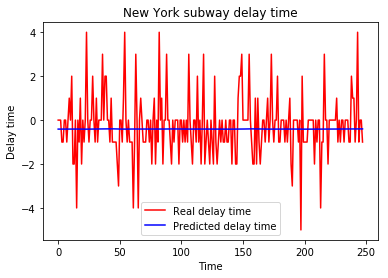

2_201_S.csv
1.7599468338777746
1.8916737586347028
Epoch 1/80
1159/1159 [==============================] - 47s 40ms/step - loss: 0.0605
Epoch 2/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0238
Epoch 3/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0223
Epoch 4/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0211
Epoch 5/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0213
Epoch 6/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0210
Epoch 7/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0200
Epoch 8/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0201
Epoch 9/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0203
Epoch 10/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0194
Epoch 11/80
1159/1159 [==============================] - 2s 2ms/step - loss: 0.0201
Epoch 12/80
1159/1159 [==========

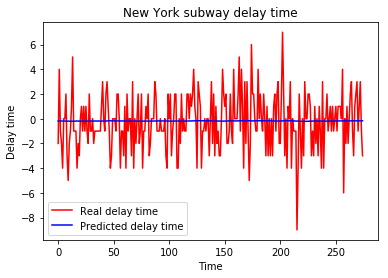

2_137_N.csv
5.376234990640826
5.005699688687259
Epoch 1/80
1784/1784 [==============================] - 48s 27ms/step - loss: 0.0348
Epoch 2/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0155
Epoch 3/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0139
Epoch 4/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0145
Epoch 5/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0138
Epoch 6/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0131
Epoch 7/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0135
Epoch 8/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0126
Epoch 9/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0125
Epoch 10/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0125
Epoch 11/80
1784/1784 [==============================] - 3s 2ms/step - loss: 0.0122
Epoch 12/80
1784/1784 [============

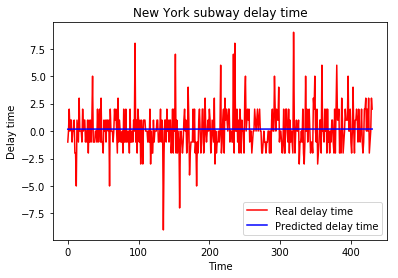

1_137_S.csv
3.068895819561971
3.8126120720572945
Epoch 1/80
1739/1739 [==============================] - 48s 28ms/step - loss: 0.0369
Epoch 2/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0149
Epoch 3/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0133
Epoch 4/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0132
Epoch 5/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0125
Epoch 6/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0124
Epoch 7/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0119
Epoch 8/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0122
Epoch 9/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0119
Epoch 10/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0116
Epoch 11/80
1739/1739 [==============================] - 3s 2ms/step - loss: 0.0112
Epoch 12/80
1739/1739 [===========

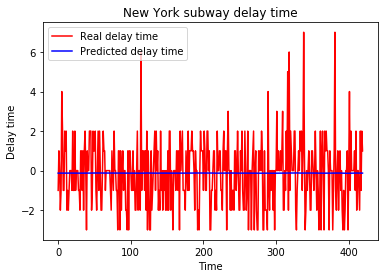

1_120_N.csv
2.8257542646534874
2.8076908829359146
Epoch 1/80
1201/1201 [==============================] - 48s 40ms/step - loss: 0.0507
Epoch 2/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0212
Epoch 3/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0199
Epoch 4/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0208
Epoch 5/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0214
Epoch 6/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0205
Epoch 7/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0202
Epoch 8/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0193
Epoch 9/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0193
Epoch 10/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0195
Epoch 11/80
1201/1201 [==============================] - 2s 2ms/step - loss: 0.0196
Epoch 12/80
1201/1201 [==========

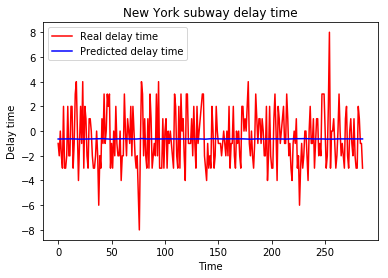

2_221_S.csv
5.147971267850582
4.750014574081312
Epoch 1/80
1211/1211 [==============================] - 46s 38ms/step - loss: 0.0601
Epoch 2/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0257
Epoch 3/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0241
Epoch 4/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0236
Epoch 5/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0234
Epoch 6/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0228
Epoch 7/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0235
Epoch 8/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0228
Epoch 9/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0216
Epoch 10/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0223
Epoch 11/80
1211/1211 [==============================] - 2s 2ms/step - loss: 0.0225
Epoch 12/80
1211/1211 [============

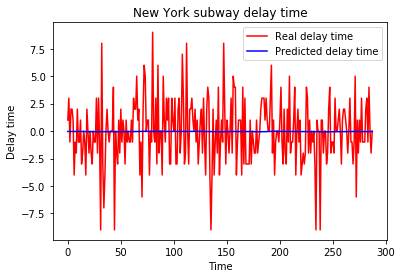

2_120_S.csv
6.086712292276439
8.117044001982045
Epoch 1/80
1732/1732 [==============================] - 48s 28ms/step - loss: 0.0379
Epoch 2/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 3/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0102
Epoch 4/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0101
Epoch 5/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0100
Epoch 6/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0094
Epoch 7/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0097
Epoch 8/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0089
Epoch 9/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0084
Epoch 10/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0087
Epoch 11/80
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0081
Epoch 12/80
1732/1732 [============

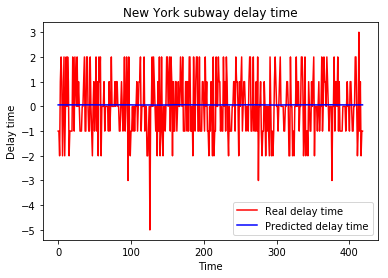

1_115_S.csv
1.8021827532162948
1.5410588708741069
Epoch 1/80
1068/1068 [==============================] - 51s 48ms/step - loss: 0.0521
Epoch 2/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0226
Epoch 3/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0220
Epoch 4/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0217
Epoch 5/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0222
Epoch 6/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0217
Epoch 7/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0211
Epoch 8/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0204
Epoch 9/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0211
Epoch 10/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0206
Epoch 11/80
1068/1068 [==============================] - 2s 2ms/step - loss: 0.0211
Epoch 12/80
1068/1068 [==========

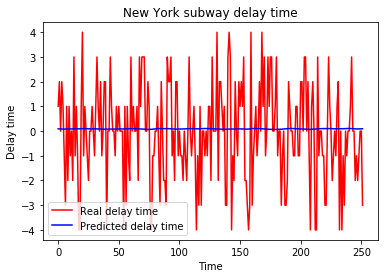

2_235_N.csv
4.4315927625166385
3.7550001841742002
Epoch 1/80
1210/1210 [==============================] - 50s 42ms/step - loss: 0.0642
Epoch 2/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0284
Epoch 3/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0260
Epoch 4/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0251
Epoch 5/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0237
Epoch 6/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0250
Epoch 7/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0243
Epoch 8/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0248
Epoch 9/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0235
Epoch 10/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0237
Epoch 11/80
1210/1210 [==============================] - 2s 2ms/step - loss: 0.0228
Epoch 12/80
1210/1210 [==========

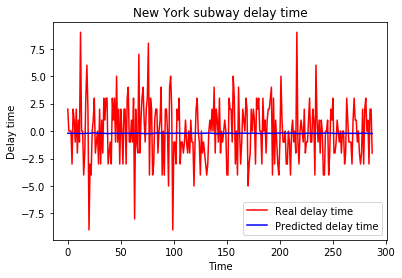

2_127_S.csv
6.4876179166022565
6.9735896766445995
Epoch 1/80
1680/1680 [==============================] - 49s 29ms/step - loss: 0.0208
Epoch 2/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0123
Epoch 3/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0121
Epoch 4/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 5/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0112
Epoch 6/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 7/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0114
Epoch 8/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0105
Epoch 9/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0104
Epoch 10/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0110
Epoch 11/80
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0103
Epoch 12/80
1680/1680 [==========

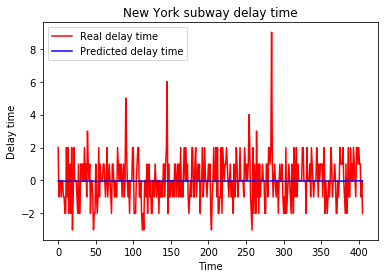

1_112_S.csv
1.7743063425213856
2.0148765770695176
Epoch 1/80
1848/1848 [==============================] - 49s 27ms/step - loss: 0.0447
Epoch 2/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0172
Epoch 3/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0161
Epoch 4/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0166
Epoch 5/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0166
Epoch 6/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0156
Epoch 7/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0154
Epoch 8/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0155
Epoch 9/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0155
Epoch 10/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0147
Epoch 11/80
1848/1848 [==============================] - 3s 2ms/step - loss: 0.0148
Epoch 12/80
1848/1848 [==========

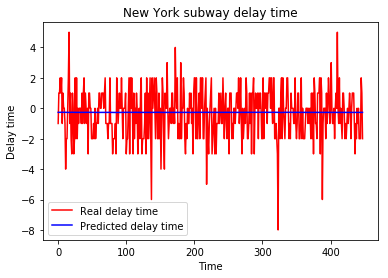

1_101_N.csv
3.955567630220006
2.6736726196147633
Epoch 1/80
1104/1104 [==============================] - 50s 45ms/step - loss: 0.0558
Epoch 2/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0257
Epoch 3/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0243
Epoch 4/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0244
Epoch 5/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0237
Epoch 6/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0228
Epoch 7/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0226
Epoch 8/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0233
Epoch 9/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0223
Epoch 10/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0247
Epoch 11/80
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0221
Epoch 12/80
1104/1104 [===========

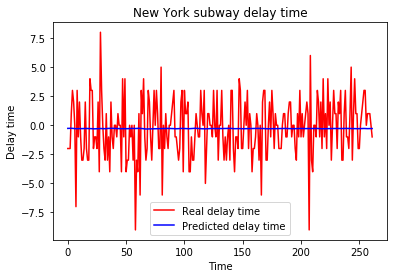

2_247_S.csv
6.137957040796504
6.1578723432601805
Epoch 1/80
1177/1177 [==============================] - 49s 42ms/step - loss: 0.0606
Epoch 2/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0272
Epoch 3/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0280
Epoch 4/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0253
Epoch 5/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0258
Epoch 6/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0258
Epoch 7/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0251
Epoch 8/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0247
Epoch 9/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0247
Epoch 10/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0248
Epoch 11/80
1177/1177 [==============================] - 2s 2ms/step - loss: 0.0252
Epoch 12/80
1177/1177 [===========

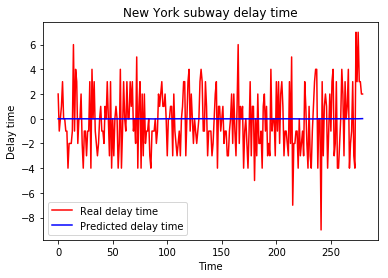

2_213_N.csv
6.812189763584059
6.338792943820024
Epoch 1/80
1777/1777 [==============================] - 52s 29ms/step - loss: 0.0438
Epoch 2/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0170
Epoch 3/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0162
Epoch 4/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0166
Epoch 5/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0158
Epoch 6/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0160
Epoch 7/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0153
Epoch 8/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0148
Epoch 9/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0151
Epoch 10/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0149
Epoch 11/80
1777/1777 [==============================] - 3s 2ms/step - loss: 0.0144
Epoch 12/80
1777/1777 [============

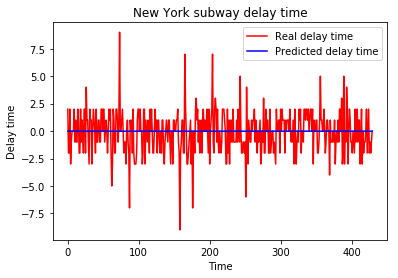

1_103_N.csv
3.8010026057482134
3.6962520887003594
Epoch 1/80
1740/1740 [==============================] - 52s 30ms/step - loss: 0.0263
Epoch 2/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0147
Epoch 3/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0143
Epoch 4/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0144
Epoch 5/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0142
Epoch 6/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0140
Epoch 7/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0136
Epoch 8/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0137
Epoch 9/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0137
Epoch 10/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0135
Epoch 11/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0132
Epoch 12/80
1740/1740 [==========

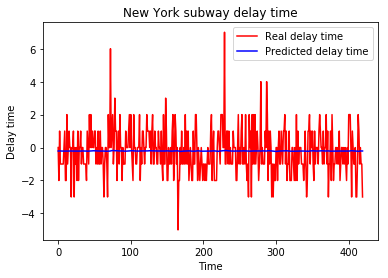

1_127_N.csv
2.37532652153317
1.9610905547250637
Epoch 1/80
1197/1197 [==============================] - 49s 41ms/step - loss: 0.0585
Epoch 2/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0233
Epoch 3/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0221
Epoch 4/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0214
Epoch 5/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0222
Epoch 6/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0213
Epoch 7/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0210
Epoch 8/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0206
Epoch 9/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0213
Epoch 10/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0207
Epoch 11/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0213
Epoch 12/80
1197/1197 [============

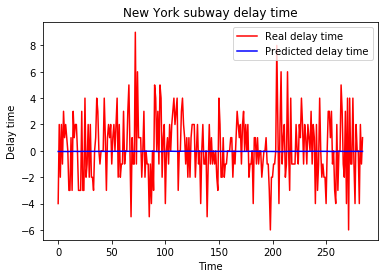

2_224_S.csv
5.500232107035074
5.797063426981471
Epoch 1/80
1164/1164 [==============================] - 52s 45ms/step - loss: 0.0574
Epoch 2/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0310
Epoch 3/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0293
Epoch 4/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0300
Epoch 5/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0290
Epoch 6/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0296
Epoch 7/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0288
Epoch 8/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0278
Epoch 9/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0288
Epoch 10/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0290
Epoch 11/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0279
Epoch 12/80
1164/1164 [============

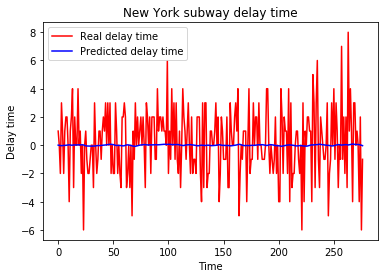

2_132_N.csv
5.677078022684379
5.598441136665708
Epoch 1/80
1122/1122 [==============================] - 51s 45ms/step - loss: 0.0542
Epoch 2/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0263
Epoch 3/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0245
Epoch 4/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0233
Epoch 5/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0238
Epoch 6/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0246
Epoch 7/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0241
Epoch 8/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0239
Epoch 9/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0230
Epoch 10/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0236
Epoch 11/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0230
Epoch 12/80
1122/1122 [============

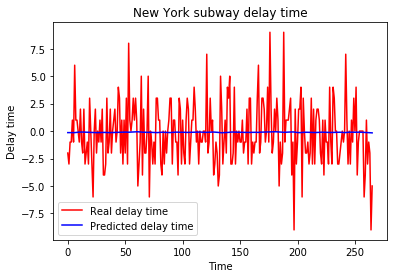

2_239_S.csv
6.293532824195949
7.703462367887241
Epoch 1/80
1715/1715 [==============================] - 52s 30ms/step - loss: 0.0311
Epoch 2/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0097
Epoch 3/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0092
Epoch 4/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0082
Epoch 5/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0081
Epoch 6/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0082
Epoch 7/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0083
Epoch 8/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0076
Epoch 9/80
1715/1715 [==============================] - 3s 1ms/step - loss: 0.0077
Epoch 10/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0073
Epoch 11/80
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0077
Epoch 12/80
1715/1715 [============

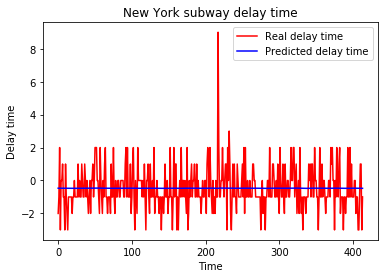

1_142_N.csv
1.4892454609182781
1.745622470441146
Epoch 1/80
1197/1197 [==============================] - 49s 41ms/step - loss: 0.0564
Epoch 2/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0194
Epoch 3/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0168
Epoch 4/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0164
Epoch 5/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0169
Epoch 6/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0155
Epoch 7/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0159
Epoch 8/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0161
Epoch 9/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0162
Epoch 10/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0157
Epoch 11/80
1197/1197 [==============================] - 2s 2ms/step - loss: 0.0160
Epoch 12/80
1197/1197 [===========

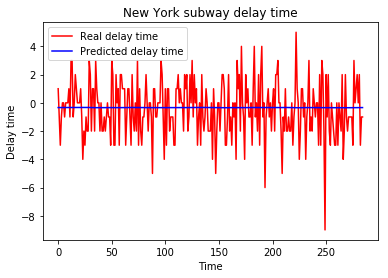

2_213_S.csv
3.8830768582421102
3.8785518631571394
Epoch 1/80
1684/1684 [==============================] - 52s 31ms/step - loss: 0.0488
Epoch 2/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0230
Epoch 3/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0220
Epoch 4/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0205
Epoch 5/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0210
Epoch 6/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0195
Epoch 7/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0204
Epoch 8/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0198
Epoch 9/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0195
Epoch 10/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0196
Epoch 11/80
1684/1684 [==============================] - 3s 2ms/step - loss: 0.0192
Epoch 12/80
1684/1684 [==========

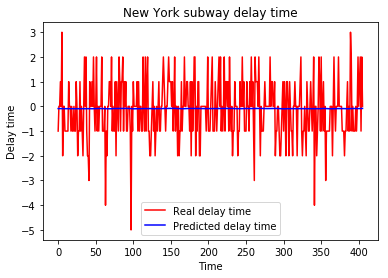

1_103_S.csv
1.2671984372235527
1.3717869628002621
Epoch 1/80
1761/1761 [==============================] - 1367s 776ms/step - loss: 0.0387
Epoch 2/80
1761/1761 [==============================] - 4s 3ms/step - loss: 0.0127
Epoch 3/80
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0125
Epoch 4/80
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0115
Epoch 5/80
1761/1761 [==============================] - 1579s 897ms/step - loss: 0.0113
Epoch 6/80
1761/1761 [==============================] - 3s 1ms/step - loss: 0.0117
Epoch 7/80
1761/1761 [==============================] - 3s 2ms/step - loss: 0.0104
Epoch 8/80
1761/1761 [==============================] - 3s 1ms/step - loss: 0.0106
Epoch 9/80
1761/1761 [==============================] - 8s 4ms/step - loss: 0.0111
Epoch 10/80
1761/1761 [==============================] - 9s 5ms/step - loss: 0.0102
Epoch 11/80
1761/1761 [==============================] - 6s 4ms/step - loss: 0.0102
Epoch 12/80
1761/1761 [==

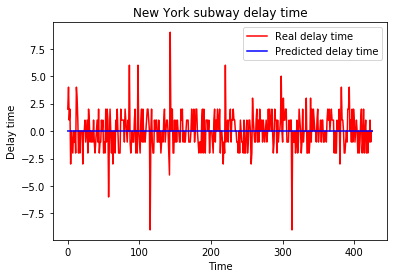

1_127_S.csv
2.3459574866240245
2.8913866978909617
Epoch 1/80
1164/1164 [==============================] - 60s 51ms/step - loss: 0.0550
Epoch 2/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0258
Epoch 3/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0254
Epoch 4/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0239
Epoch 5/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0241
Epoch 6/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0244
Epoch 7/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0244
Epoch 8/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0232
Epoch 9/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0222
Epoch 10/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0231
Epoch 11/80
1164/1164 [==============================] - 2s 2ms/step - loss: 0.0221
Epoch 12/80
1164/1164 [==========

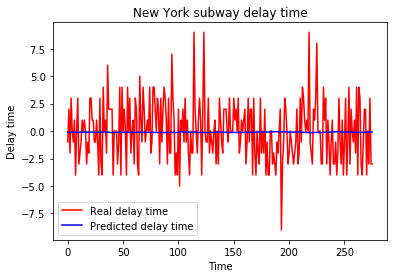

2_224_N.csv
6.141385588061789
7.212037739038839
Epoch 1/80
1122/1122 [==============================] - 60s 53ms/step - loss: 0.0749
Epoch 2/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0303
Epoch 3/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0260
Epoch 4/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0262
Epoch 5/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0264
Epoch 6/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0256
Epoch 7/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0249
Epoch 8/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0252
Epoch 9/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0244
Epoch 10/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0251
Epoch 11/80
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0257
Epoch 12/80
1122/1122 [============

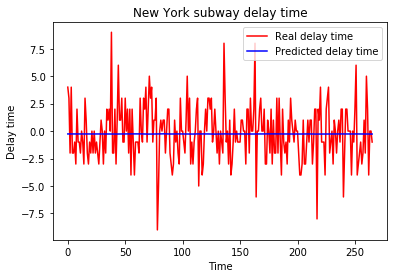

2_235_S.csv
6.806658900668175
6.298663672473479
Epoch 1/80
1172/1172 [==============================] - 79s 68ms/step - loss: 0.0479
Epoch 2/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0241
Epoch 3/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0225
Epoch 4/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0231
Epoch 5/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0234
Epoch 6/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0224
Epoch 7/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0228
Epoch 8/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0222
Epoch 9/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0218
Epoch 10/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0215
Epoch 11/80
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0210
Epoch 12/80
1172/1172 [============

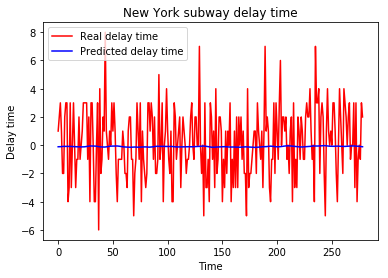

2_127_N.csv
5.186767384034825
6.16760310117186
Epoch 1/80
1905/1905 [==============================] - 62s 32ms/step - loss: 0.0409
Epoch 2/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0151
Epoch 3/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0151
Epoch 4/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0147
Epoch 5/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0137
Epoch 6/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0131
Epoch 7/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0134
Epoch 8/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0134
Epoch 9/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0130
Epoch 10/80
1905/1905 [==============================] - 4s 2ms/step - loss: 0.0130
Epoch 11/80
1905/1905 [==============================] - 3s 2ms/step - loss: 0.0126
Epoch 12/80
1905/1905 [=============

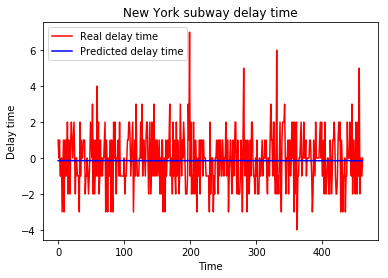

1_112_N.csv
3.203819040103282
2.3733004162344726
Epoch 1/80
1563/1563 [==============================] - 55s 35ms/step - loss: 0.0190
Epoch 2/80
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0098
Epoch 3/80
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0098
Epoch 4/80
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0098
Epoch 5/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0096
Epoch 6/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0095
Epoch 7/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0092
Epoch 8/80
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0092
Epoch 9/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0091
Epoch 10/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0091
Epoch 11/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0089
Epoch 12/80
1563/1563 [===========

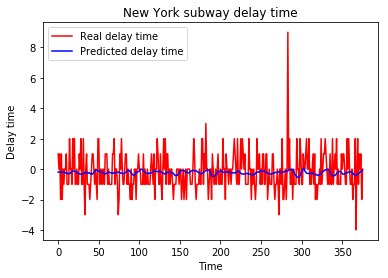

1_101_S.csv
1.3443634365812764
1.5432310738645
Epoch 1/80
1018/1018 [==============================] - 54s 53ms/step - loss: 0.0363
Epoch 2/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0163
Epoch 3/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0139
Epoch 4/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0151
Epoch 5/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0141
Epoch 6/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0145
Epoch 7/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0145
Epoch 8/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0139
Epoch 9/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 10/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0143
Epoch 11/80
1018/1018 [==============================] - 2s 2ms/step - loss: 0.0136
Epoch 12/80
1018/1018 [=============

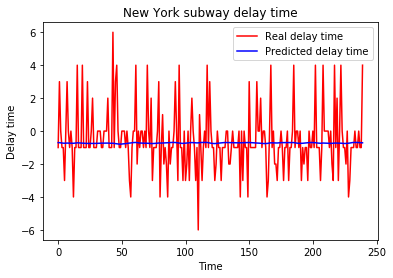

2_247_N.csv
2.700173252916304
3.4266526722072066
Epoch 1/80
1212/1212 [==============================] - 62s 51ms/step - loss: 0.0718
Epoch 2/80
1212/1212 [==============================] - 2s 2ms/step - loss: 0.0291
Epoch 3/80
1212/1212 [==============================] - 2s 2ms/step - loss: 0.0282
Epoch 4/80
1212/1212 [==============================] - 2s 2ms/step - loss: 0.0261
Epoch 5/80
1212/1212 [==============================] - 2s 2ms/step - loss: 0.0265
Epoch 6/80
1212/1212 [==============================] - 3s 2ms/step - loss: 0.0262
Epoch 7/80
1212/1212 [==============================] - 3s 2ms/step - loss: 0.0258
Epoch 8/80
1212/1212 [==============================] - 2s 2ms/step - loss: 0.0254
Epoch 9/80
1212/1212 [==============================] - 2s 2ms/step - loss: 0.0260
Epoch 10/80
1212/1212 [==============================] - 2s 2ms/step - loss: 0.0252
Epoch 11/80
1212/1212 [==============================] - 2s 2ms/step - loss: 0.0250
Epoch 12/80
1212/1212 [===========

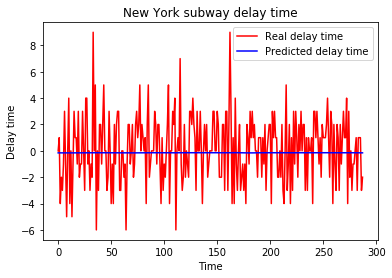

2_132_S.csv
7.008767648852455
6.329809726189193
Epoch 1/80
1072/1072 [==============================] - 64s 60ms/step - loss: 0.0453
Epoch 2/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0216
Epoch 3/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0220
Epoch 4/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0213
Epoch 5/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0203
Epoch 6/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0202
Epoch 7/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0200
Epoch 8/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0200
Epoch 9/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0201
Epoch 10/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0195
Epoch 11/80
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0194
Epoch 12/80
1072/1072 [============

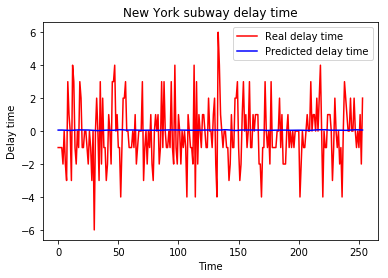

2_239_N.csv
3.7507941860837466
3.306924470719801
Epoch 1/80
1787/1787 [==============================] - 55s 31ms/step - loss: 0.0365
Epoch 2/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0144
Epoch 3/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0126
Epoch 4/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0129
Epoch 5/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0128
Epoch 6/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0129
Epoch 7/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0122
Epoch 8/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0118
Epoch 9/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0124
Epoch 10/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0116
Epoch 11/80
1787/1787 [==============================] - 3s 2ms/step - loss: 0.0119
Epoch 12/80
1787/1787 [===========

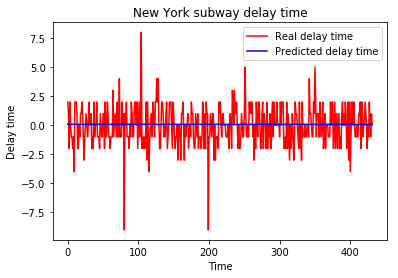

1_142_S.csv
2.829947174337116
2.903627071219589
Epoch 1/80
1709/1709 [==============================] - 59s 35ms/step - loss: 0.0383
Epoch 2/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0121
Epoch 3/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 4/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 5/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0111
Epoch 6/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0103
Epoch 7/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0102
Epoch 8/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0097
Epoch 9/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0102
Epoch 10/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0091
Epoch 11/80
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0092
Epoch 12/80
1709/1709 [============

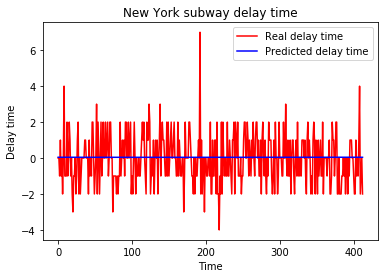

1_124_S.csv
2.05741340350743
1.9482430686168517
Epoch 1/80
1744/1744 [==============================] - 58s 33ms/step - loss: 0.0357
Epoch 2/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0119
Epoch 3/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0102
Epoch 4/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0099
Epoch 5/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0097
Epoch 6/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0098
Epoch 7/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0099
Epoch 8/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0096
Epoch 9/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0092
Epoch 10/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0087
Epoch 11/80
1744/1744 [==============================] - 3s 2ms/step - loss: 0.0094
Epoch 12/80
1744/1744 [============

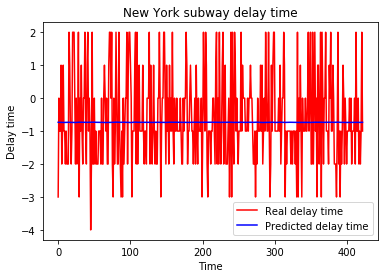

1_137_N.csv
2.174940898659648
1.8916452222168951
Epoch 1/80
1740/1740 [==============================] - 55s 31ms/step - loss: 0.0349
Epoch 2/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0111
Epoch 3/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0109
Epoch 4/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0107
Epoch 5/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0106
Epoch 6/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0101
Epoch 7/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0095
Epoch 8/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0094
Epoch 9/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0097
Epoch 10/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0090
Epoch 11/80
1740/1740 [==============================] - 3s 2ms/step - loss: 0.0096
Epoch 12/80
1740/1740 [===========

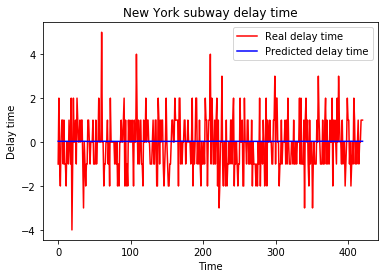

1_119_S.csv
1.8363656454395367
1.5671791742775336
Epoch 1/80
1050/1050 [==============================] - 58s 55ms/step - loss: 0.0573
Epoch 2/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0252
Epoch 3/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0253
Epoch 4/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0245
Epoch 5/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0237
Epoch 6/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0235
Epoch 7/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0227
Epoch 8/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0223
Epoch 9/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0234
Epoch 10/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0231
Epoch 11/80
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0231
Epoch 12/80
1050/1050 [==========

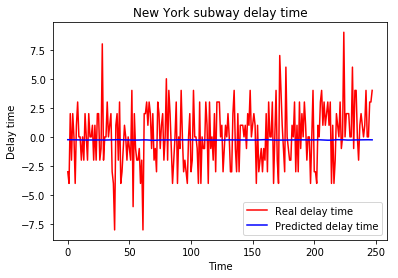

2_201_N.csv
6.18908588969704
6.886883294477597
Epoch 1/80
1217/1217 [==============================] - 52s 43ms/step - loss: 0.0609
Epoch 2/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0284
Epoch 3/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0281
Epoch 4/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0267
Epoch 5/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0275
Epoch 6/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0264
Epoch 7/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0264
Epoch 8/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0257
Epoch 9/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0257
Epoch 10/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0255
Epoch 11/80
1217/1217 [==============================] - 2s 2ms/step - loss: 0.0258
Epoch 12/80
1217/1217 [=============

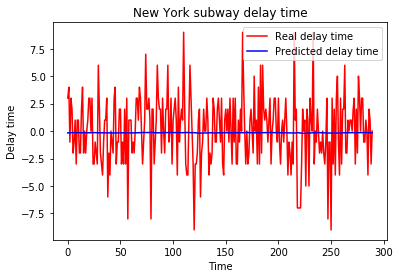

2_137_S.csv
7.069295843820699
9.22904083947897
Epoch 1/80
1176/1176 [==============================] - 53s 45ms/step - loss: 0.0680
Epoch 2/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0298
Epoch 3/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0284
Epoch 4/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0289
Epoch 5/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0270
Epoch 6/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0281
Epoch 7/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0268
Epoch 8/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0266
Epoch 9/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0275
Epoch 10/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0261
Epoch 11/80
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0266
Epoch 12/80
1176/1176 [=============

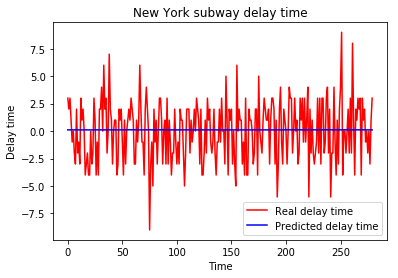

2_221_N.csv
7.427978456760025
7.2364589068465905
Epoch 1/80
1173/1173 [==============================] - 61s 52ms/step - loss: 0.0606
Epoch 2/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0244
Epoch 3/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0237
Epoch 4/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0230
Epoch 5/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0231
Epoch 6/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0220
Epoch 7/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0220
Epoch 8/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0225
Epoch 9/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0224
Epoch 10/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0219
Epoch 11/80
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0225
Epoch 12/80
1173/1173 [===========

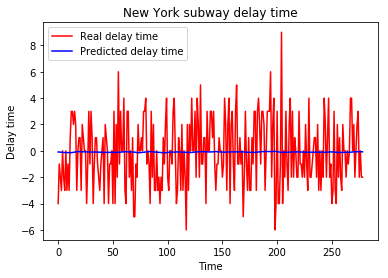

2_120_N.csv
5.907349474705571
6.548431690195301
Epoch 1/80
1920/1920 [==============================] - 58s 30ms/step - loss: 0.0382
Epoch 2/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0160
Epoch 3/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0151
Epoch 4/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0144
Epoch 5/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0146
Epoch 6/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0142
Epoch 7/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0137
Epoch 8/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0132
Epoch 9/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0138
Epoch 10/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0128
Epoch 11/80
1920/1920 [==============================] - 3s 2ms/step - loss: 0.0131
Epoch 12/80
1920/1920 [============

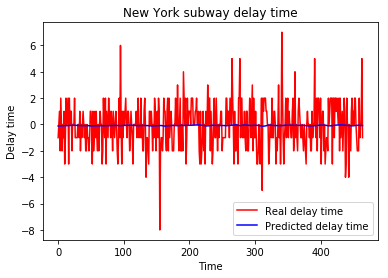

1_115_N.csv
3.349572418031069
2.9157093948322452
Epoch 1/80
1746/1746 [==============================] - 63s 36ms/step - loss: 0.0273
Epoch 2/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0117
Epoch 3/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0108
Epoch 4/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0100
Epoch 5/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0105
Epoch 6/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0100
Epoch 7/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0096
Epoch 8/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0099
Epoch 9/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0095
Epoch 10/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0095
Epoch 11/80
1746/1746 [==============================] - 3s 2ms/step - loss: 0.0092
Epoch 12/80
1746/1746 [===========

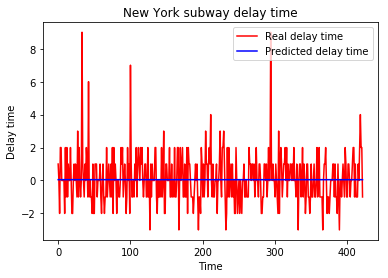

1_120_S.csv
1.8679076499949898
2.2513052536209397


In [209]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

def dataset_reshape(scaled):
    X_train = []
    y_train = []
    
    length = scaled.shape[0]
    for i in range(20,length):
        X_train.append(scaled[i-20:i,0])
        y_train.append(scaled[i,0])
    X_train,y_train = np.array(X_train),np.array(y_train)
    X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    return X_train,y_train

for filename in filenames:
    filename_new = filename.replace('.csv','')
    line,stationID,stationDIR = filename_new.split('_')
    cur_dir = datasets_folder+'/'+filename
    data = pandas.read_csv(cur_dir,header=None)
    data.columns = ['month','date','hour','temp','pressure','humidity',
                   'wind_speed','wind_direction','clouds','weather_code',
                   'minute','delay']
    training_set = data.iloc[:,11:].values
    #training_set_reshape = training_set.reshape(-1,1)
    data_scaled = sc.fit_transform(training_set)
    train, test = train_test_split(data_scaled,test_size=0.2)
    X_train,y_train = dataset_reshape(train)
    X_test,y_test = dataset_reshape(test)
    mse_train,mse_test = rnn_regr(X_train,X_test,y_train,y_test)
    print(filename)
    print(mse_train)
    print(mse_test)    